# Trajectory interpolation

Notebook: Lukas Winiwarter, 2023

In this demo, we present how an existing or external trajectory can be used to model platform location and attitude in a HELIOS++ simulation.

In [1]:
from pathlib import Path
from IPython.display import Code
from pyhelios.util.xmldisplayer import display_xml, find_playback_dir

In [2]:
import os
os.chdir("..")

## Survey

In this example, we simulate an airborne laser scanner acquisition flying inside of a box of 100 m side length. This allows us to see the full point pattern. We set the `platform` to `interpolated`, and define a trajectory file in the `<platformSettings >` tag. This is provided by a filename and a column order. By setting `syncGPSTime`, we ensure that the output point cloud is in the same time system as the input trajectory.

In [3]:
Code(display_xml('data/surveys/demo/box_survey_interp.xml'))

<document>
    <scannerSettings id="scaset" active="true" pulseFreq_hz="180000" scanFreq_hz="100" />

    <survey name="box_interpolation" scene="data/scenes/demo/box_scene.xml#box_scene" platform="interpolated" basePlatform="data/platforms.xml#sr22" scanner="data/scanners_als.xml#riegl_lms-q560">
		<leg>
            <platformSettings trajectory="data/trajectories/flyandrotate.trj" tIndex="0" xIndex="4" yIndex="5" zIndex="6" rollIndex="1" pitchIndex="2" yawIndex="3" slopeFilterThreshold="0.0" toRadians="true" syncGPSTime="true" tStart="0" tEnd="5" teleportToStart="true" />  
			<scannerSettings template="scaset" trajectoryTimeInterval_s="0.01" />
        </leg>
		<leg>
            <platformSettings trajectory="data/trajectories/flyandrotate.trj" tStart="5" tEnd="10" teleportToStart="true" />
			<scannerSettings template="scaset" trajectoryTimeInterval_s="0.01" />
        </leg>
    </survey>
</document>

The contents of the trajectory file are simple: For the first 2.5 seconds, we move from `(0, -40, 0)` to `(0, 0, 0)`, with a constant attitude of `(0,0,0)` (roll, pitch, yaw). In the next 2.5 seconds, we continue to move to `(0, 40, 0)`, but rotate (roll) until we have an attitude of `(90, 0, 0)`. HELIOS++ linearly interpolates between these values.

The second half of the file show a movement from `(-40, 0, 0)` to `(40, 0, 0)`. Note how, for the `interpolated` platform, the `yaw` angle has to be set explicitely, in this case to `90` degrees (i.e., due east). Apart from these changes, the 

In [4]:
Code(open('data/trajectories/flyandrotate.trj').read())

#TIME_COLUMN: 0
#HEADER: "t", "roll", "pitch", "yaw", "x", "y", "z"
0, 0, 0, 0, 0, -40, 0
2.5, 0, 0, 0, 0, 0, 0
5, 90, 0, 0, 0, 40, 0
5, 0, 0, 90, -40, 0, 0
7.5, 0, 0, 90, 0, 0, 0
10, 90, 0, 90, 40, 0, 0

## Execute the simulation

In [6]:
!helios data/surveys/demo/box_survey_interp.xml

HELIOS++ VERSION 0.1.dev1003+g06ef94c.d20240213

CWD: "/home/dkempf/helios"
seed: AUTO
surveyPath: "data/surveys/demo/box_survey_interp.xml"
assetsPath: "assets/"
outputPath: "output/"
writeWaveform: 0
writePulse: 0
calcEchowidth: 0
fullWaveNoise: 0
splitByChannel: 0
parallelization: 1
njobs: 0
chunkSize: 32
warehouseFactor: 4
platformNoiseDisabled: 0
legNoiseDisabled: 0
rebuildScene: 0
lasOutput: 0
las10: 0
fixedIncidenceAngle: 0
gpsStartTime: 
kdtType: 4
kdtJobs: 0
kdtGeomJobs: 0
sahLossNodes: 32

xmlDocFilename: box_survey_interp.xml
xmlDocFilePath: data/surveys/demo
xmlDocFilename: scanners_als.xml
xmlDocFilePath: data
Using default value for attribute 'averagePower_w' : 4
Using default value for attribute 'beamQualityFactor' : 1
Using default value for attribute 'opticalEfficiency' : 0.99
Using default value for attribute 'receiverDiameter_m' : 0.15
Using default value for attribute 'atmosphericVisibility_km' : 23
Using default value for attribute 'wavelength_nm' : 1064
Scanner: r

## Results

Now let's find the output files and display a 3D plot.

/tmp/ipykernel_118256/2975681461.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Loading points from /home/dkempf/helios/output/box_interpolation/2024-02-13_10-54-03


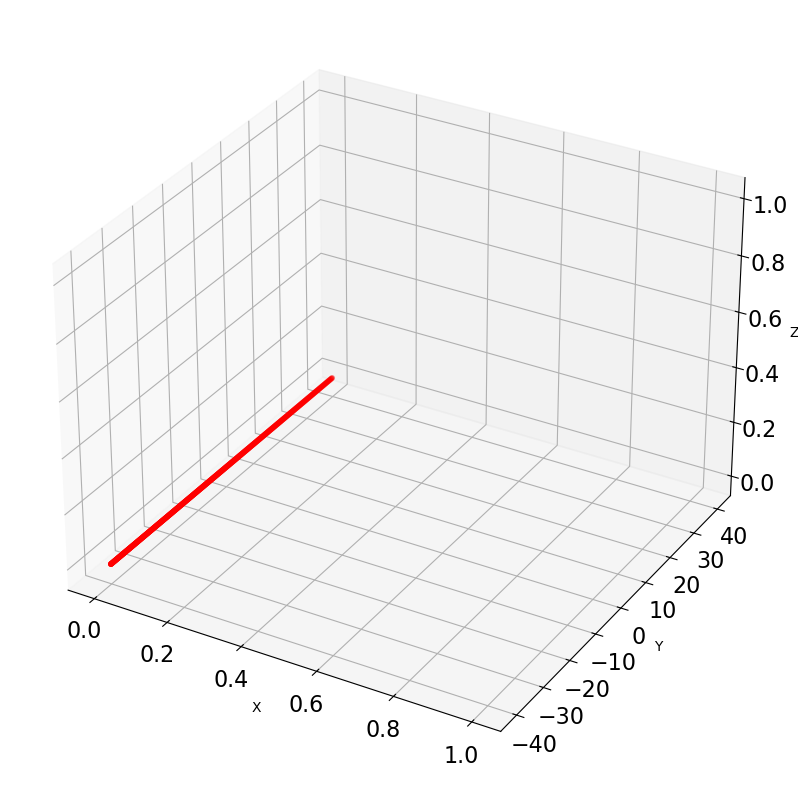

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

output_path = find_playback_dir("data/surveys/demo/box_survey_interp.xml")

print("Loading points from", output_path)
PC = pd.read_csv(Path(output_path) / 'leg000_points.xyz', 
                  names="X Y Z intensity echoWidth returnNumber numberOfReturns fullwaveIndex hitObjectId class gpsTime".split(' '),
                  delimiter=' ')
trj = pd.read_csv(Path(output_path) / 'leg000_trajectory.txt', 
                  names="X Y Z gpsTime roll pitch yaw".split(' '),
                  delimiter=' ')

PC1 = PC[PC['gpsTime'] <= 2.5]  # select all points recorded in the first half
PC2 = PC[PC['gpsTime'] > 2.5]  # select all points recorded in the second half

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(PC1['X'], PC1['Y'], PC1['Z'], s=0.001, c=PC1['gpsTime']) 
ax.scatter(PC2['X'], PC2['Y'], PC2['Z'], s=0.001, c=PC2['gpsTime']) 
ax.scatter(trj['X'], trj['Y'], trj['Z'], s=10, c='red') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.tick_params(labelsize=16)
plt.show()

In the first plot, we see the platform travelling along th y-axis. After 2.5 seconds, it reaches (0,0,0), and starts rolling (right wing downwards). In consequence, the laser swath travels left and upwards on the face of the cube.

In the second plot (below), the same thing happens, but with a different orientation (yaw angle).

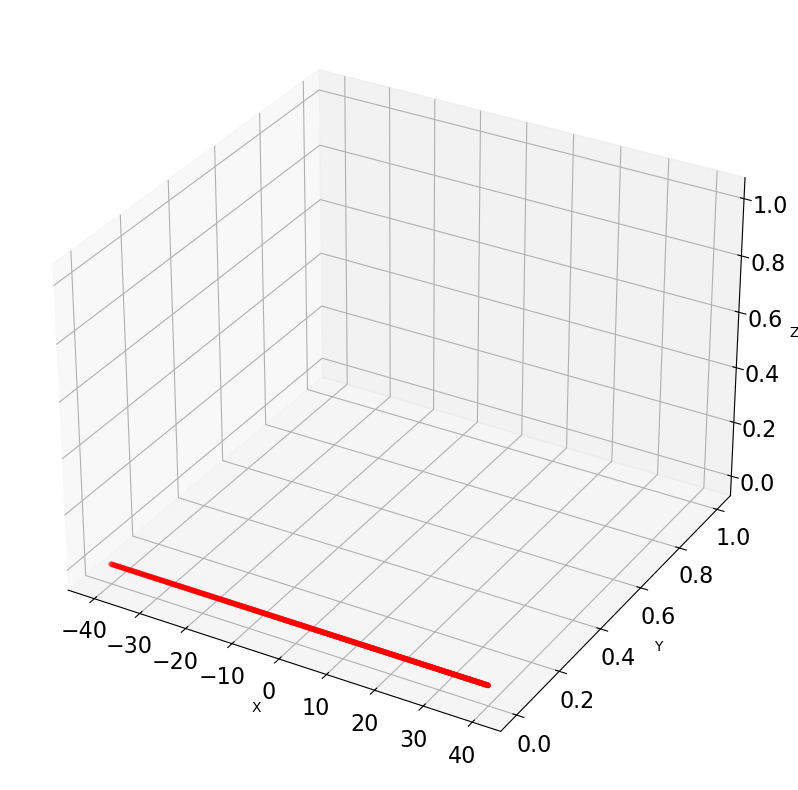

In [8]:
PC = pd.read_csv(Path(output_path) / 'leg001_points.xyz', 
                  names="X Y Z intensity echoWidth returnNumber numberOfReturns fullwaveIndex hitObjectId class gpsTime".split(' '),
                  delimiter=' ')
trj = pd.read_csv(Path(output_path) / 'leg001_trajectory.txt', 
                  names="X Y Z gpsTime roll pitch yaw".split(' '),
                  delimiter=' ')

PC1 = PC[PC['gpsTime'] <= 7.5]  # select all points recorded in the first half
PC2 = PC[PC['gpsTime'] > 7.5]  # select all points recorded in the second half

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(PC1['X'], PC1['Y'], PC1['Z'], s=0.001, c=PC1['gpsTime']) 
ax.scatter(PC2['X'], PC2['Y'], PC2['Z'], s=0.001, c=PC2['gpsTime']) 
ax.scatter(trj['X'], trj['Y'], trj['Z'], s=10, c='red') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.tick_params(labelsize=16)
plt.show()